# CS375 - Assignment 1


## GaborNet training and testing

In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

In [42]:
from dldata.metrics.utils import compute_metric_base

### Getting data from the database
Let's connect to the database and pull the test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [3]:
# connect to database
dbname = 'assignment1'
collname = 'gabornet'
exp_id = '1st_experiment'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))

[u'1st_experiment']


This shows us all stored experiments. In case you want to delete a particular experiment because you are running out of disk space, you can uncomment and use the following line. You could also just drop the entire collection or even the entire database if you want to get of all of them, but I recommend removing them one by one.

## Neural analysis
We will first pull the data which was stored in the validation results in the database. Therefore, we call the function 'get_neural_validation_data'. The returned 'validation_data' is a list of dictionaries that contain your validation results. Its keys contain amongst others the 'exp_id' of your experiment, the evaluated 'step', and the actual 'validation_results'.

In [6]:
def get_neural_validation_data(exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

validation_data = get_neural_validation_data(exp_id=exp_id)
print('data keys:')
print(validation_data[0].keys())

data keys:
[u'exp_id', 'step', u'_id', u'validates', u'validation_results']


In [22]:
target_layers = ['conv1']
idx = 0 ### YOUR idx HERE
data_all = validation_data[idx]['validation_results']['VAll']
data_6 = validation_data[idx]['validation_results']['V6']
step = validation_data[idx]['step']

### Analyzing the RDM results

We will start with visualizing the RDMs you computed for each layer and the IT neurons. 

Please implement 'plot_rdms' that visualizes the rdms of all target_layers and displays the layer name as well as the spearman_corrcoef and the iteration step in the plot title.


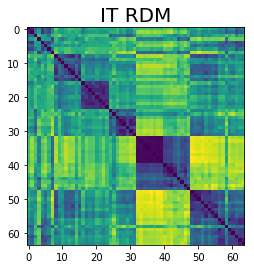

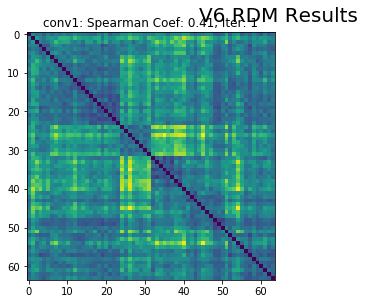

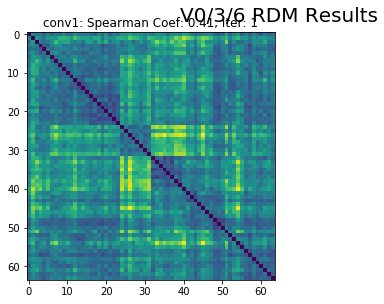

In [23]:
from math import ceil

def plot_rdms(data, target_layers, step):
    """
    Displays the RDMs of all target layers.
    
    You will need to EDIT this part. Please implement a function that visualizes 
    the rdms of all target_layers and displays the layer name as well as the 
    spearman_corrcoef in the plot title.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for i, layer in enumerate(target_layers):
        rdm = data['rdm_%s' % layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer]
        ### YOUR CODE HERE
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(rdm)
        plt.title('%s: Spearman Coef: %.2f, Iter: %s' % (layer, spearman_corrcoef, step))
        ### END OF YOUR CODE
    plt.tight_layout()


plt.title('IT RDM', fontsize=20)
plt.imshow(data_all['rdm_it'])

plot_rdms(data_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)

Unsurprisingly, the RDM of our gabor model does not look much like the RDM of IT neurons - it has much less structure and is kind of a lukewarm muddy mess. This is because the information being encoded by the responses of the gabor battery is mostly about pixel-level features of the images, which are not well correlated with their category memberships. The patterns which are visible here are incidental low-level image similarities, as opposed to the strong within-category representational similarities seen in the black boxes of the IT RDM.

### Analyzing the categorization results

Now let's visualize the results of the categorization test we performed for each layer. 

Your task is to plot the confusion matrix 'cms' across all categorized classes for each layer. You will need 'cms', 'labelset' and 'accbal' from data['categorization_"insert_target_layer_here"']['result_summary']. Label the x and y axis with 'labelset'. Put the layer name, average accuracy and the iteration step in the plot title. To get the average accuracy substract 0.5 from the mean of 'accbal' and multiply the result with 2. Describe what you see.

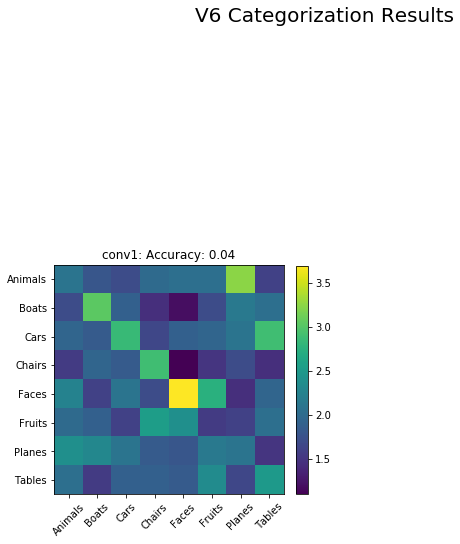

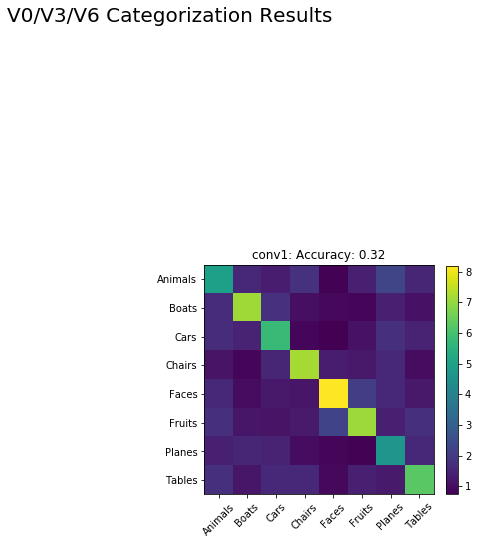

In [38]:
def plot_categorization_results(data, target_layers, step,j):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    #ncols = 2
    #nrows = ceil(len(target_layers)/ncols)
    #plot_size = 4
    f = plt.figure(figsize=(10, 10))

    #for i, layer in enumerate(target_layers):
    i=0
    layer = 'conv1'
    k = 'categorization_%s' % layer
    categorization_results = data[k]['result_summary']
    ### YOUR CODE HERE
    confusion = np.vstack([np.mean(performance, 1) for performance in categorization_results['cms']])
    acc = (np.mean(categorization_results['accbal'])-.5)*2 # why this?
    # plot
    plt.subplot(1, 2, j)
    plt.imshow(confusion)
    plt.xticks(range(8), categorization_results['labelset'], rotation=45)
    plt.yticks(range(8), categorization_results['labelset'])
    plt.colorbar(fraction=.045)
    plt.title('%s: Accuracy: %.2f' % (layer, acc))
        ### END OF YOUR CODE
    #plt.tight_layout()
        
plot_categorization_results(data_6, target_layers, step,1)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_all, target_layers, step,2)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)


The gabor filters perform pretty poorly on the high-variation data set, but actually function surprisingly well overall. This is likely driven by the simplicity of the V0 images, where pixel-level features at the centers of the images are somewhat effective for determining image category. We see a particularly good recognition of faces, which is even visible in the high variation condition. This may be related to the unique and reliable features of exemplar faces - for example the strong vertical edge of the nose and the horizontal edges formed by the eyes. These features could be read out directly from the activity patterns of a few particular gabor filters. Other categories like fruits don't have any such consistent features across exemplars.

### Analyzing the within categorization reuslts

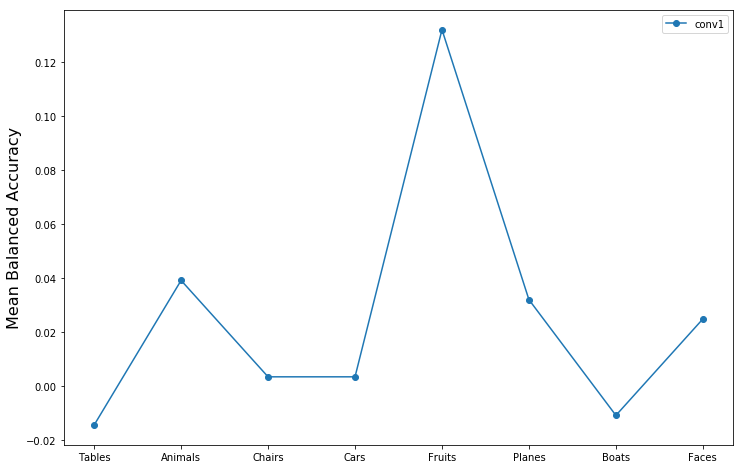

In [33]:
def plot_within_categorization_results(data, target_layers):
    plt.figure(figsize=(12,8))
    for i, layer in enumerate(target_layers):
        layer_results = data_6['within_categorization_%s' % layer]
        performance = [(k, (np.mean(v['result_summary']['accbal'])-.5)*2) for k,v in layer_results.items()]
        plt.plot([i[1] for i in performance], '-o', label=layer)
    plt.xticks(range(len(performance)), [i[0] for i in performance])
    plt.ylabel('Mean Balanced Accuracy', fontsize=16)
    plt.legend()
    
    
plot_within_categorization_results(data_6, target_layers)


I'm not sure if any of the differences here are significant, but it's possible that fruits are some of the most-different exemplars within a category. The variety of contours and features present in different fruits may allow them to be idividually identified from the network's responses. While the group-similarity of faces helped for the categorization performance, by the same token it is very difficult to tell any one face from another based on the readouts of the gabors.

### Analyzing the regression results

We will now display the results of the regression test. 

Please print (1 - data['it\_regression_"insert_target_layer_here"']['noise_corrected_multi_rsquared_loss']) for each layer and step and label the print out with the layer name and step. Describe what you observe.

In [35]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
        
print('********** V 6 *********************')
plot_regression_results(data_6, target_layers, step)
print('\n********** V All ******************')
plot_regression_results(data_all, target_layers, step)

********** V 6 *********************
layer: conv1, step: 1, performance: 0.09

********** V All ******************
layer: conv1, step: 1, performance: 0.15


Both of these show quite poor relation to the neural data. Again this is not surprising given that the gabor filters in the model are more similar to the types of tuning curves seen in early visual areas like V1 than those in IT which are thought to be responding to category-level information.

### Rotation Regression

In [36]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'meta_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
        
print('********** V 6 *********************')
plot_regression_results(data_6, target_layers, step)
print('\n********** V All ******************')
plot_regression_results(data_all, target_layers, step)

********** V 6 *********************
layer: conv1, step: 1, performance: -0.01

********** V All ******************
layer: conv1, step: 1, performance: -0.01


The gabor network completely fails here, again because the feature in question has no easily accessible representation at the pixel level.

### Visualizing the conv1 kernels
Lastly, we will plot the conv1 filter kernels. 

Your task is to visualize the 'conv1_kernel' in a 12 x 8 grid. Therefore, you just have to plot each kernel as an image in a subplot. The kernels are stored in data['conv1_kernel']. Print out the iteration step and plot the kernels and describe what you see.

Iteration step: 1


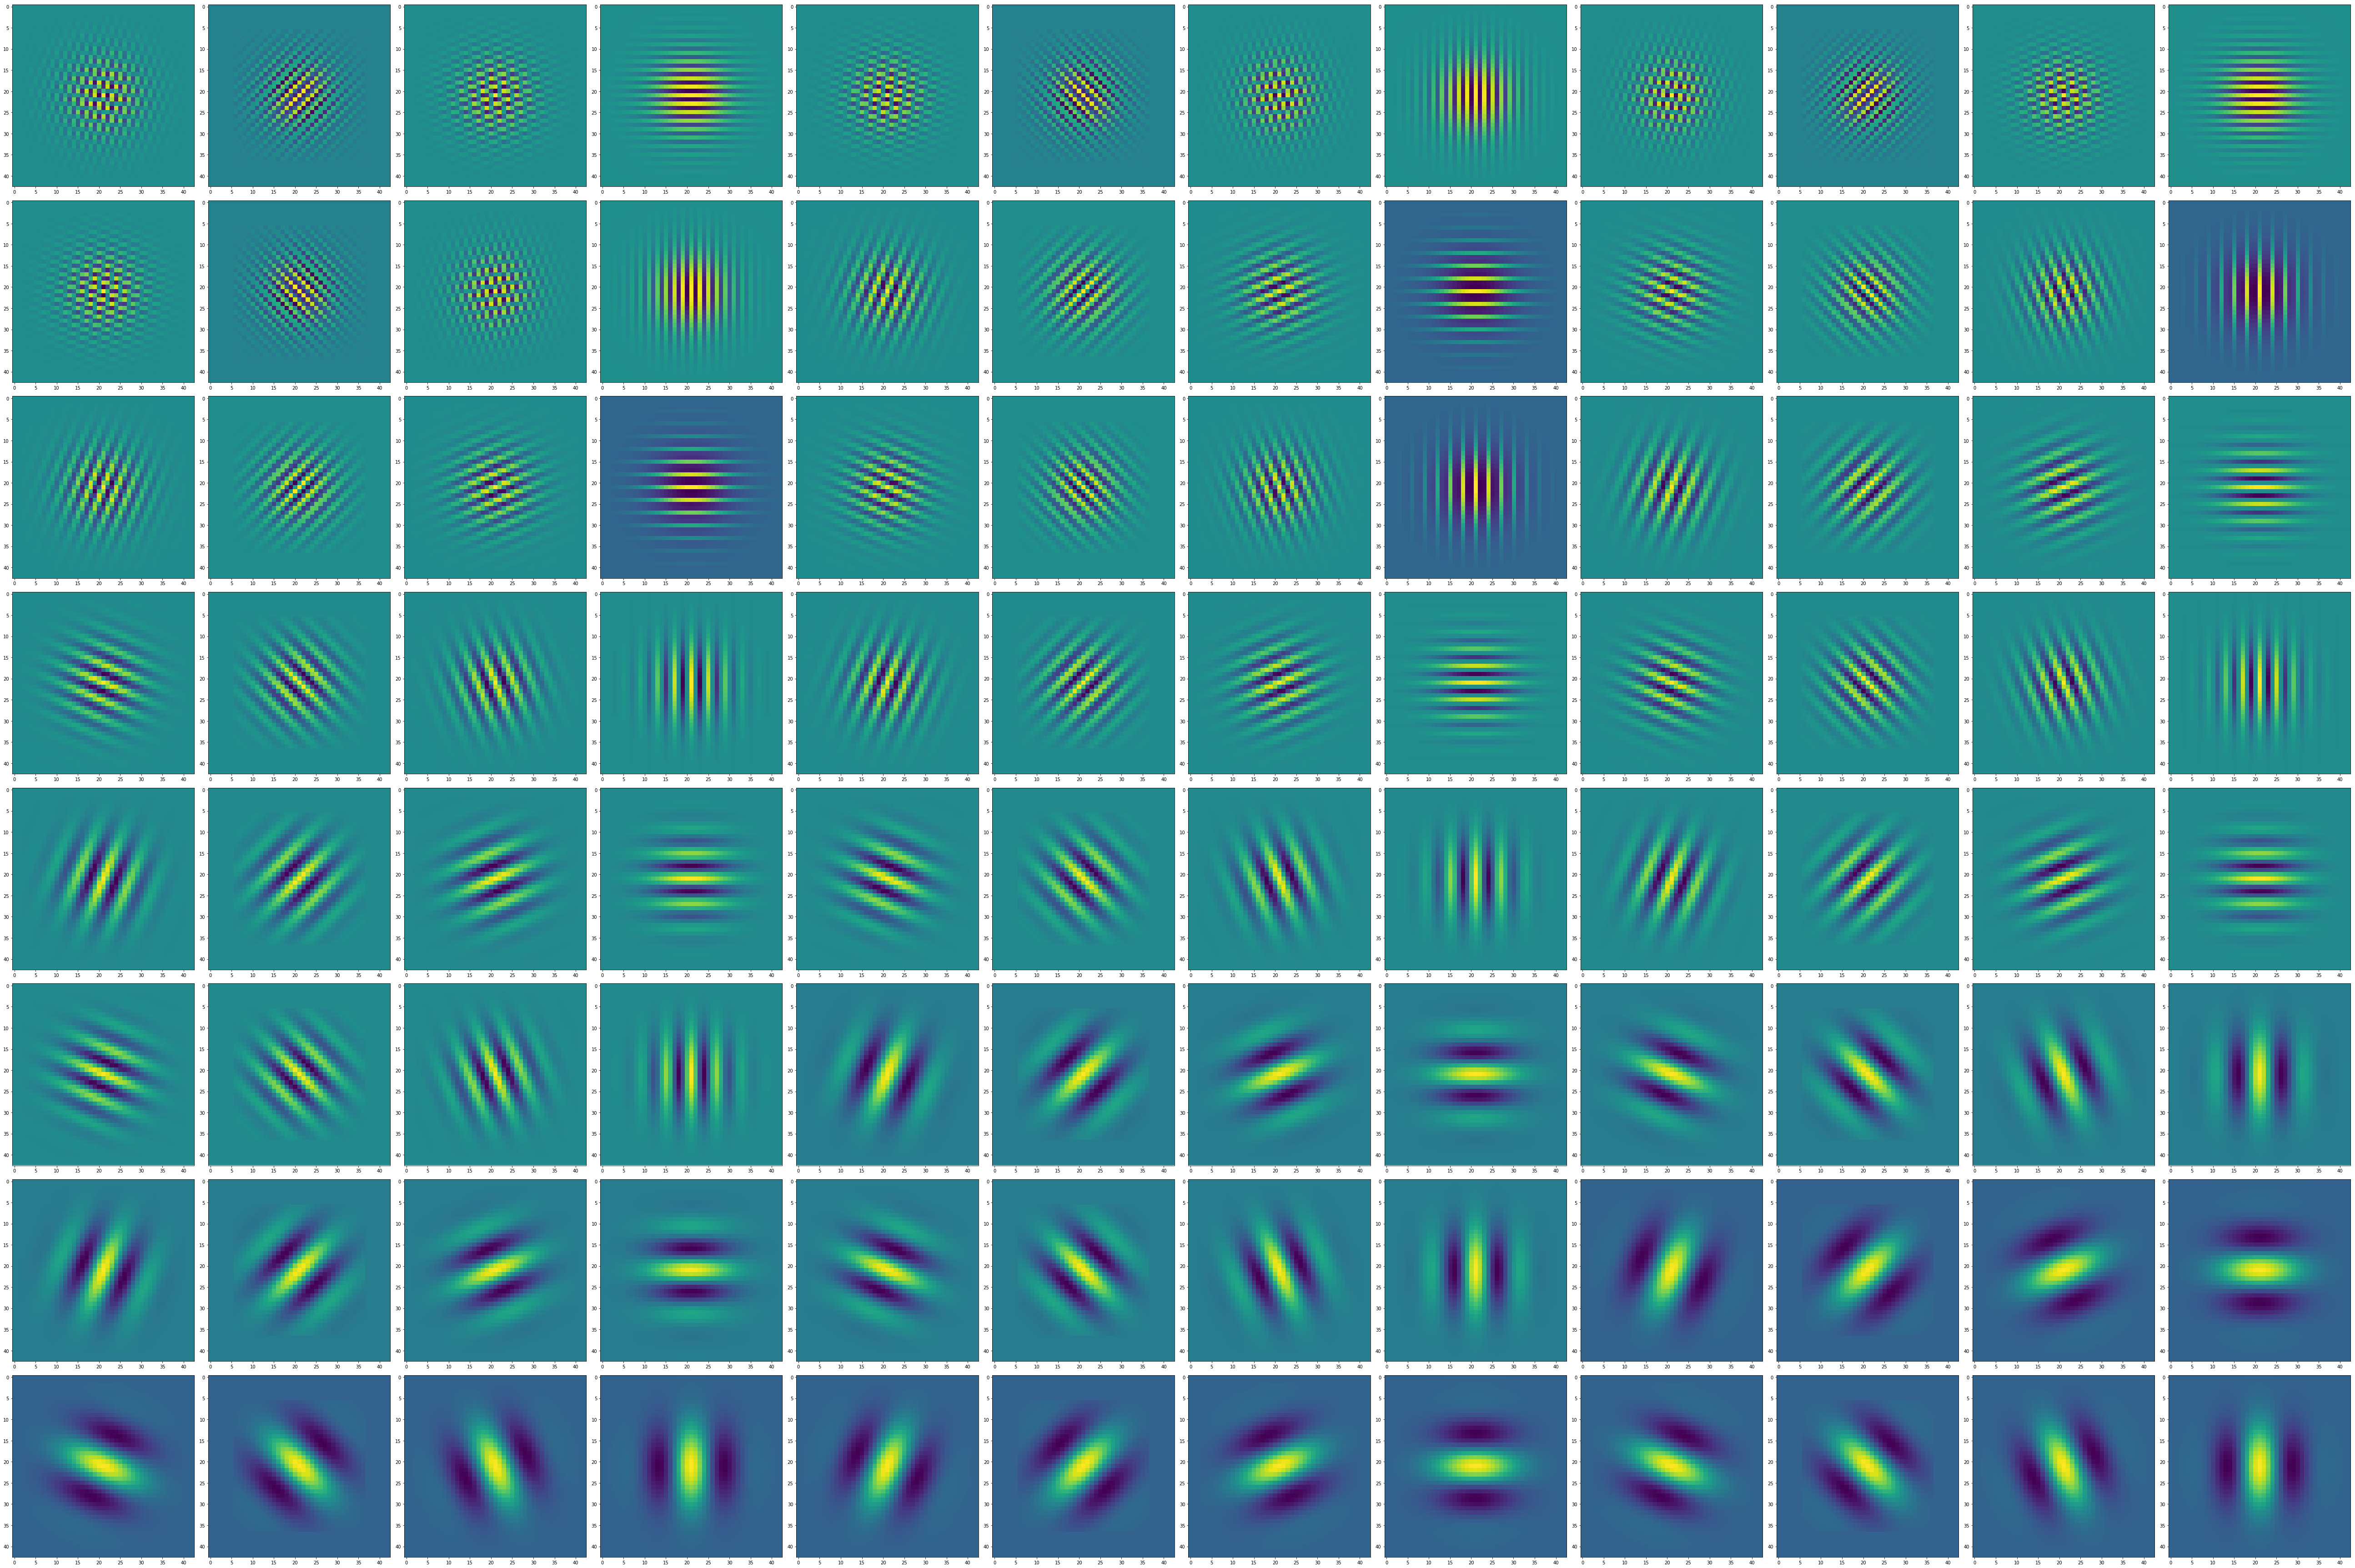

In [41]:
def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv1_kernel'])
    ### YOUR CODE HERE
    xc = 0
    yc = 0
    ncols = 12
    nrows = 8
    plot_size = 6
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for kernelID in range(12*8):
        kernel = kernels[:,:,1,kernelID]
        plt.subplot(nrows, ncols, kernelID+1)
        plt.imshow(kernel)
    plt.tight_layout()
    ### END OF YOUR CODE
           
plot_conv1_kernels(data_all, step)

These are the hard-coded gabor filters we programmed into the network; 96 gabors at 6 spatial frequencies and 16 orientations.